In [2]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('advertising').getOrCreate()

In [12]:
advertising = spark.read.json('AdDataset.json')
ad = spark.read.json('AdDataset_2.json')


In [4]:
advertising.show()
advertising.columns

ad.show()
ad.columns

+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|            Ad_Topic|             City|Click|             Country|Daily Internet Usage|Daily Time Spent on Site| ID|Male|       Timestamp|
+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|Cloned 5thgenerat...|      Wrightburgh|    0|             Tunisia|              256.09|                   68.95|  1|   0|27-03-2016 00:53|
|Monitored nationa...|        West Jodi|    0|               Nauru|              193.77|                   80.23|  2|   1|04-04-2016 01:39|
|Organic bottom-li...|         Davidton|    0|          San Marino|               236.5|                   69.47|  3|   0|13-03-2016 20:35|
|Triple-buffered r...|   West Terrifurt|    0|               Italy|              245.89|                   74.15|  4|   1|10-01-2016 02:31|
|Robust logistical..

['Age', 'Area Income', 'ID']

In [5]:
ad.describe().show()

+-------+------------------+------------------+------------------+
|summary|               Age|       Area Income|                ID|
+-------+------------------+------------------+------------------+
|  count|              1638|              1638|              1638|
|   mean|50.217948717948715|  51063.3769814653|             819.5|
| stddev|19.228160858771865|12757.313650973787|472.99418601077963|
|    min|                19|           13996.5|                 1|
|    max|                80|           79484.8|              1638|
+-------+------------------+------------------+------------------+



In [83]:
advertising.printSchema()

root
 |-- Ad_Topic: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Click: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- ID: long (nullable = true)
 |-- Male: long (nullable = true)
 |-- Timestamp: string (nullable = true)



In [22]:
advertising.select("Click").distinct().collect()

[Row(Click=0), Row(Click=1)]

In [23]:
advertising.filter(advertising.Click.isNull()).count()

0

In [21]:
advertising = advertising.na.fill({'click':'1'})

In [25]:
import seaborn as sns

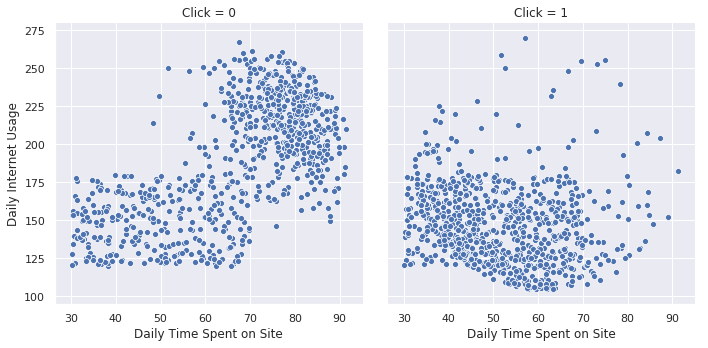

In [88]:
sns.relplot(x="Daily Time Spent on Site", y="Daily Internet Usage", col="Click", 
            data=advertising.toPandas())

In [89]:
advertising.show()

+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|            Ad_Topic|             City|Click|             Country|Daily Internet Usage|Daily Time Spent on Site| ID|Male|       Timestamp|
+--------------------+-----------------+-----+--------------------+--------------------+------------------------+---+----+----------------+
|Cloned 5thgenerat...|      Wrightburgh|    0|             Tunisia|              256.09|                   68.95|  1|   0|27-03-2016 00:53|
|Monitored nationa...|        West Jodi|    0|               Nauru|              193.77|                   80.23|  2|   1|04-04-2016 01:39|
|Organic bottom-li...|         Davidton|    0|          San Marino|               236.5|                   69.47|  3|   0|13-03-2016 20:35|
|Triple-buffered r...|   West Terrifurt|    0|               Italy|              245.89|                   74.15|  4|   1|10-01-2016 02:31|
|Robust logistical..

In [94]:
adNew = advertising.join(ad, on=['ID'], how='inner')

In [96]:
adNew.printSchema()

root
 |-- ID: long (nullable = true)
 |-- Ad_Topic: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Click: long (nullable = true)
 |-- Country: string (nullable = true)
 |-- Daily Internet Usage: double (nullable = true)
 |-- Daily Time Spent on Site: double (nullable = true)
 |-- Male: long (nullable = true)
 |-- Timestamp: string (nullable = true)
 |-- Age: long (nullable = true)
 |-- Area Income: double (nullable = true)



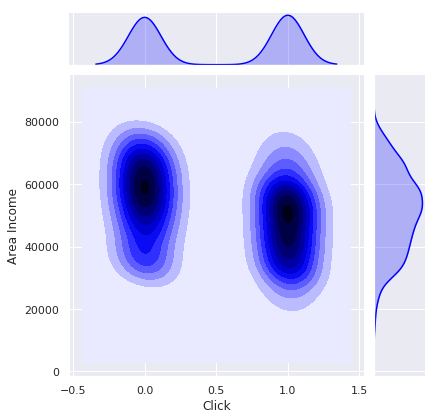

In [183]:
sns.jointplot(x="Click",y="Area Income",data=adNew.toPandas(), color = "blue", kind='kde')


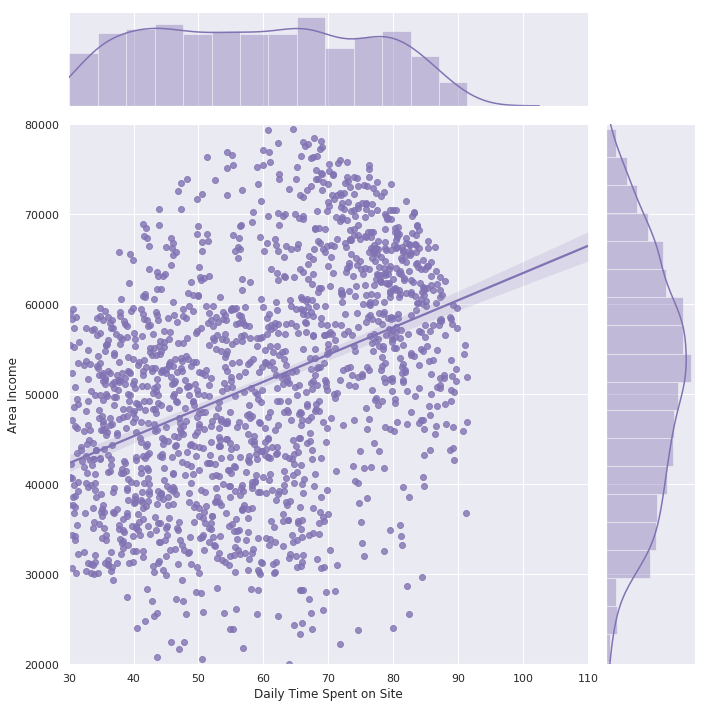

In [184]:
sns.set(style="darkgrid")


joint = sns.jointplot("Daily Time Spent on Site", "Area Income", data=adNew.toPandas(), kind="reg",
                  xlim=(30, 110), ylim=(20000,80000), color="m", height=10)

In [97]:
adNew.createOrReplaceTempView('data')
adNew = spark.sql("SELECT * FROM data")

In [98]:
adNew = spark.sql("SELECT * FROM data WHERE Age < 60")

In [99]:
adNew = adNew.drop('City','Country')

In [100]:
from pyspark.ml.classification import LogisticRegression

In [101]:
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer,IndexToString)


In [102]:
AdTopic_Conversion = StringIndexer(inputCol='Ad_Topic',outputCol='adTopic').fit(adNew)
adNew = AdTopic_Conversion.transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|
|  5|Robust logistical...|    0|              225.58|                   68.37|   0|03-06-2016 03:36| 35|   73889.99|    3.0|


In [103]:
from pyspark.ml.feature import Bucketizer
bin = Bucketizer(splits=[ 0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 73, float('Inf') ],inputCol="adTopic", outputCol="Ad_bins")
adNew = bin.setHandleInvalid("keep").transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|    1.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|    1.0|
|  5|Robust logistical...|    0|              225.58|                

In [104]:
bin = Bucketizer(splits=[ 0, 50, 100, 150, 200, 250, 300, float('Inf') ],inputCol="Daily Internet Usage", outputCol="Internet_Bins")
adNew = bin.setHandleInvalid("keep").transform(adNew)

adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|Internet_Bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|          5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|          3.0|
|  3|Organic bottom-li...|    0|               236.5|                   69.47|   0|13-03-2016 20:35| 26|   59785.94|    6.0|    1.0|          4.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|  

In [105]:
train_data, test_data = adNew.randomSplit([0.7,.3])

In [106]:
adNew = adNew.drop('Ad_Topic')

In [125]:
assembler = VectorAssembler(inputCols=['ID',
 'Age',
 'Daily Internet Usage',
 'Daily Time Spent on Site',
 'Internet_Bins',                                    
 'adTopic',                                   
 'Male',
 'Area Income'],outputCol='features')

In [126]:
from pyspark.ml import Pipeline

In [127]:
lr = LogisticRegression(featuresCol='features',labelCol='Click')

In [128]:
pipeline_lr = Pipeline(stages=[assembler,lr])

In [129]:
train_data.show()
adNew.show()

+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
| ID|            Ad_Topic|Click|Daily Internet Usage|Daily Time Spent on Site|Male|       Timestamp|Age|Area Income|adTopic|Ad_bins|Internet_Bins|
+---+--------------------+-----+--------------------+------------------------+----+----------------+---+-----------+-------+-------+-------------+
|  1|Cloned 5thgenerat...|    0|              256.09|                   68.95|   0|27-03-2016 00:53| 35|    61833.9|    5.0|    0.0|          5.0|
|  2|Monitored nationa...|    0|              193.77|                   80.23|   1|04-04-2016 01:39| 31|   68441.85|    8.0|    1.0|          3.0|
|  4|Triple-buffered r...|    0|              245.89|                   74.15|   1|10-01-2016 02:31| 29|   54806.18|    7.0|    1.0|          4.0|
|  8|Reactive local ch...|    1|              131.76|                    66.0|   1|07-03-2016 01:40| 48|   24593.33|  

In [130]:
fit_lr = pipeline_lr.fit(train_data)

In [131]:
results_lr = fit_lr.transform(test_data)

In [132]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

predictionLR = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')

In [133]:
results_lr.select('Click','prediction').show()

+-----+----------+
|Click|prediction|
+-----+----------+
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    1|       1.0|
|    0|       0.0|
|    1|       1.0|
+-----+----------+
only showing top 20 rows



In [134]:
accuracyLR = predictionLR.evaluate(results_lr)

accuracyLR

0.9750503018108652

In [177]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier


In [178]:
assemblerDT = VectorAssembler(inputCols=['ID',
 'Age',
 'Daily Internet Usage',
 'Daily Time Spent on Site',
 'Ad_bins',                                      
 'Male',
 'Area Income'],outputCol='features')

In [179]:
dt = DecisionTreeRegressor(featuresCol="features", labelCol = "Click")
rf = RandomForestClassifier(labelCol='Click',featuresCol='features')
gbt = GBTClassifier(labelCol='Click',featuresCol='features')

In [181]:
pipelineDT = Pipeline(stages=[assemblerDT, dt])
pipelineRF = Pipeline(stages=[assemblerDT, rf])
pipelineGBT = Pipeline(stages=[assemblerDT, gbt])

In [182]:
modelDT = pipelineDT.fit(train_data)
modelRF = pipelineRF.fit(train_data)
modelGBT = pipelineGBT.fit(train_data)

In [193]:
predictionDT = modelDT.transform(test_data)
predictionRF = modelRF.transform(test_data)
predictionGBT = modelGBT.transform(test_data)


In [194]:
predictionDT.select("prediction", "Click", "features").show(20)


+-------------------+-----+--------------------+
|         prediction|Click|            features|
+-------------------+-----+--------------------+
|0.02702702702702703|    0|[3.0,26.0,236.5,6...|
|0.02702702702702703|    0|[5.0,35.0,225.58,...|
| 0.2857142857142857|    0|[6.0,23.0,226.74,...|
|0.02702702702702703|    0|[7.0,33.0,208.36,...|
|                1.0|    1|[13.0,48.0,113.12...|
|                1.0|    1|[16.0,23.0,140.64...|
|                1.0|    1|[17.0,37.0,129.41...|
|                1.0|    1|[19.0,36.0,118.39...|
|                1.0|    1|[20.0,40.0,135.51...|
|0.02702702702702703|    0|[22.0,35.0,226.54...|
|0.02702702702702703|    0|[31.0,35.0,267.01...|
|                1.0|    1|[33.0,57.0,169.23...|
|                1.0|    1|[39.0,46.0,119.32...|
|0.02702702702702703|    0|[45.0,25.0,204.86...|
|                1.0|    1|[49.0,37.0,123.72...|
|                1.0|    1|[53.0,45.0,193.58...|
|                1.0|    1|[54.0,50.0,133.2,...|
|                1.0

In [203]:
predictDT = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyDT = predictDT.evaluate(predictionDT)
print('DT: {0:2.1f}%'.format(accuracyDT*100))

DT: 93.7%


In [205]:
predictionRF.select("prediction", "Click").show(20)



+----------+-----+
|prediction|Click|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
+----------+-----+
only showing top 20 rows



In [202]:
predictRF = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyRF = predictRF.evaluate(predictionRF)
print('RF: {0:2.1f}%'.format(accuracyRF*100))

RF: 95.7%


In [204]:
predictionGBT.select("prediction", "Click").show(20)


+----------+-----+
|prediction|Click|
+----------+-----+
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       1.0|    1|
|       0.0|    0|
|       1.0|    1|
+----------+-----+
only showing top 20 rows



In [201]:
predictGBT = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Click')
accuracyGBT = predictGBT.evaluate(predictionGBT)
print('GBT: {0:2.1f}%'.format(accuracyGBT*100))

GBT: 94.3%


In [206]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [208]:
nb = NaiveBayes(smoothing=1.0, modelType="multinomial", featuresCol='features', labelCol='Click', predictionCol='prediction', probabilityCol='probability')


In [210]:
pipelineNB = Pipeline(stages=[assemblerDT, nb])


In [212]:
modelNB = pipelineNB.fit(train_data)


In [213]:
predictionNB = modelNB.transform(test_data)


In [215]:
predictionNB.select("prediction", "Click").show(20)

+----------+-----+--------------------+
|prediction|Click|         probability|
+----------+-----+--------------------+
|       0.0|    0|[1.0,2.8684418565...|
|       0.0|    0|[1.0,6.3025572582...|
|       0.0|    0|[1.0,2.9379005145...|
|       0.0|    0|[1.0,5.3755569380...|
|       0.0|    1|[1.0,5.3576589801...|
|       0.0|    1|[1.0,9.4480445083...|
|       0.0|    1|[1.0,6.5323917427...|
|       0.0|    1|[1.0,6.9653483779...|
|       0.0|    1|[1.0,1.1653511742...|
|       0.0|    0|[1.0,3.7980576449...|
|       0.0|    0|[1.0,1.4151295050...|
|       0.0|    1|[1.0,1.7536036033...|
|       0.0|    1|[1.0,2.1287293732...|
|       0.0|    0|[1.0,3.5384998538...|
|       0.0|    1|[1.0,7.5863870563...|
|       0.0|    1|[1.0,9.4185987387...|
|       0.0|    1|[1.0,5.5547188061...|
|       0.0|    1|[1.0,3.5414650678...|
|       0.0|    0|[1.0,4.2170064973...|
|       0.0|    1|[1.0,7.5941517642...|
+----------+-----+--------------------+
only showing top 20 rows



In [216]:
evaluatorNB = MulticlassClassificationEvaluator(labelCol="Click", predictionCol="prediction",
                                              metricName="accuracy")

In [219]:
accuracyNB = evaluatorNB.evaluate(predictionNB)
print('NB: {0:2.1f}%'.format(accuracyNB*100))

NB: 61.3%
